In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
# Define transformations: Convert images to tensors & normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor (0 to 1)
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download and load MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Split into training (80%), validation (10%), test (10%)
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 902kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [ ]:
# ========== 4. MLP model ==========
class MLPClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim=128, output_dim=10):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # input shall be (batch_size, 784)
        x = self.fc1(x)
        x = self.relu1(x)
        # x = self.fc2(x)
        # x = self.relu2(x)
        x = self.fc3(x)
        return x

# input size = 784

# initialize model
model = MLPClassifier(input_dim=784)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
# ========== 5. Train MLP ==========
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.view(batch_x.size(0), -1)  # Flatten input
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.view(batch_x.size(0), -1)  # Flatten input
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f},\
           Train Acc: {train_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f},\
            Val Acc: {val_accs[-1]:.4f}")


Epoch 1/50 - Train Loss: 0.3718,           Train Acc: 0.8902 | Val Loss: 0.2303,            Val Acc: 0.9298
Epoch 2/50 - Train Loss: 0.1867,           Train Acc: 0.9440 | Val Loss: 0.1733,            Val Acc: 0.9433
Epoch 3/50 - Train Loss: 0.1372,           Train Acc: 0.9584 | Val Loss: 0.1463,            Val Acc: 0.9553
Epoch 4/50 - Train Loss: 0.1156,           Train Acc: 0.9641 | Val Loss: 0.1369,            Val Acc: 0.9592
Epoch 5/50 - Train Loss: 0.1000,           Train Acc: 0.9691 | Val Loss: 0.1274,            Val Acc: 0.9640
Epoch 6/50 - Train Loss: 0.0852,           Train Acc: 0.9728 | Val Loss: 0.1096,            Val Acc: 0.9657
Epoch 7/50 - Train Loss: 0.0788,           Train Acc: 0.9750 | Val Loss: 0.1299,            Val Acc: 0.9612
Epoch 8/50 - Train Loss: 0.0748,           Train Acc: 0.9762 | Val Loss: 0.1086,            Val Acc: 0.9652
Epoch 9/50 - Train Loss: 0.0664,           Train Acc: 0.9775 | Val Loss: 0.1051,            Val Acc: 0.9693
Epoch 10/50 - Train Loss: 0.

In [16]:
# ========== 6. test ==========
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        _, predicted = outputs.max(1)
        y_true.extend(batch_y.tolist())
        y_pred.extend(predicted.tolist())

# R², MSE, Accuracy
accuracy = accuracy_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R² Score: {r2:.4f}")

Test Accuracy: 0.9732
Test MSE: 0.5373
Test R² Score: 0.9359


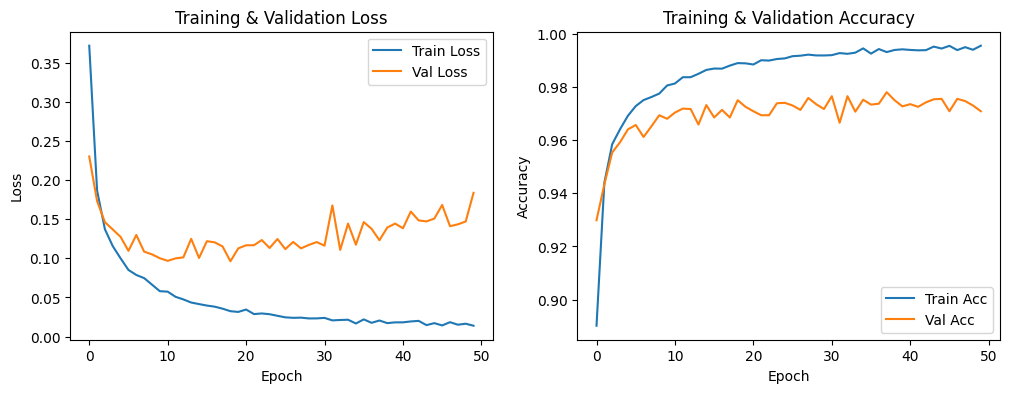

In [17]:
# ========== 7. train visualization ==========
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()